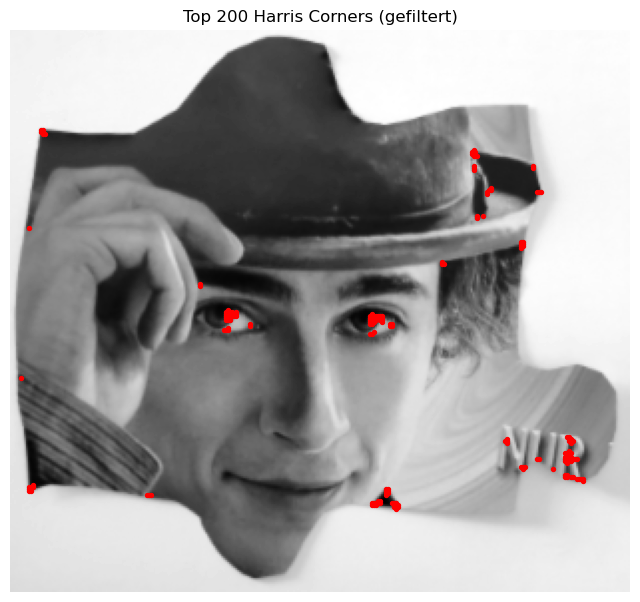

In [ ]:
import numpy as np
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
from scipy.signal import convolve2d
from scipy.ndimage import gaussian_filter


# 1. Lade das Bild über relativen Pfad aus ../data/pzl_1/
image_path = Path("..") / "data" / "poster_puzzle_edited" / "wonka_003_edited.png"
image_path_full = Path("..") / "data" / "poster_puzzle_edited" / "wonka_full_edited.png"



# ----------------------------------------
# Funktion: Graustufenbild laden
# ----------------------------------------
def load_grayscale_image(path):
    """
    Lädt ein Bild vom gegebenen Pfad und wandelt es in ein 2D-Graustufen-Array um (float32).
    
    Warum?
    - Harris Corner Detection benötigt ein einzelnes Intensitätsbild.
    - float32 für numerisch stabile Berechnungen.
    """
    img = Image.open(path).convert("L")  # "L" = grayscale mode
    return np.array(img, dtype=np.float32)

# ----------------------------------------
# Funktion: Harris Corner Detection
# ----------------------------------------
def harris_corner_detection(image, k=0.05, window_size=5, threshold=0):
    """
    Führt Harris-Corner-Detection auf einem gegebenen Graustufenbild aus.

    Parameter:
    - k: Empfindlichkeitsfaktor für Ecken (typisch 0.04–0.06)
    - window_size: Fenstergröße für lokale Summen (z. B. 3x3 oder 5x5)
    - threshold: Mindest-R-Wert (meist 0, Filterung später sinnvoller)

    Rückgabe:
    - corners: Binärmaske der Ecken (nur Score > threshold)
    - R: vollständige Corner-Response Matrix
    """
    # Sobel-Filter zur Gradientenberechnung
    sobel_x = np.array([[-1, 0, 1],
                        [-2, 0, 2],
                        [-1, 0, 1]], dtype=np.float32)
    sobel_y = np.array([[-1, -2, -1],
                        [ 0,  0,  0],
                        [ 1,  2,  1]], dtype=np.float32)

    # Bildgradienten berechnen
    Ix = convolve2d(image, sobel_x, mode='same', boundary='symm')
    Iy = convolve2d(image, sobel_y, mode='same', boundary='symm')

    # Gradientprodukte
    Ix2 = Ix ** 2
    Iy2 = Iy ** 2
    Ixy = Ix * Iy

    # Lokale Summierung der Produkte über Fenster
    w = np.ones((window_size, window_size))
    Sx2 = convolve2d(Ix2, w, mode='same', boundary='symm')
    Sy2 = convolve2d(Iy2, w, mode='same', boundary='symm')
    Sxy = convolve2d(Ixy, w, mode='same', boundary='symm')

    # Harris-Matrix: R = det(M) - k * (trace(M))²
    detM = Sx2 * Sy2 - Sxy ** 2
    traceM = Sx2 + Sy2
    R = detM - k * (traceM ** 2)

    # Nur Werte über Schwelle behalten (optional – meist threshold = 0)
    corners = (R > threshold) * R
    return corners, R

# ----------------------------------------
# Funktion: Stärkste Ecken extrahieren
# ----------------------------------------
def filter_strongest_corners(corner_response, threshold_ratio=0.03, max_corners=200):
    """
    Filtert die stärksten Ecken basierend auf ihrem Harris-Score.

    Parameter:
    - corner_response: Corner-Response-Matrix (R-Werte)
    - threshold_ratio: Prozentwert von max(R), um schwache Ecken rauszufiltern
    - max_corners: Anzahl der besten Ecken, die zurückgegeben werden

    Rückgabe:
    - x, y: Koordinaten der stärksten Ecken
    """
    max_r = np.max(corner_response)
    threshold = max_r * threshold_ratio

    y, x = np.where(corner_response > threshold)
    scores = corner_response[y, x]

    sorted_indices = np.argsort(-scores)
    selected_indices = sorted_indices[:max_corners]

    return x[selected_indices], y[selected_indices]

# ----------------------------------------
# Anwendungsteil
# ----------------------------------------


image = load_grayscale_image(image_path)

# 2. Skalierung: halbiert das Bild, um Rechenlast zu reduzieren und glättet das Detailniveau
#image = image[::2, ::2]

# 3. Helligkeit normalisieren: bringt Werte in 0–255 Bereich → wichtig für stabilen Kontrast
image = (image - np.min(image)) / (np.max(image) - np.min(image)) * 255

# 4. Rauschen entfernen und Übergänge glätten, ohne Ecken zu zerstören
image = gaussian_filter(image, sigma=0.53)

# 5. Harris Corner Detection durchführen
corners, response = harris_corner_detection(
    image, 
    k=0.08,            # empfindlicher für Ecken mit kleinen Intensitätsänderungen
    window_size=3,     # kleines Fenster → präzise Lokalisierung
    threshold=0        # alle Punkte behalten, Filterung kommt danach
)

# 6. Ecken filtern: nur die stärksten 200 behalten
x_strong, y_strong = filter_strongest_corners(
    response, 
    threshold_ratio=0.025, 
    max_corners=200
)

# 7. Visualisierung
plt.figure(figsize=(8, 8))
plt.imshow(image, cmap='gray')
plt.scatter(x_strong, y_strong, c='red', s=8)
plt.title("Top 200 Harris Corners (gefiltert)")
plt.axis('off')
plt.show()






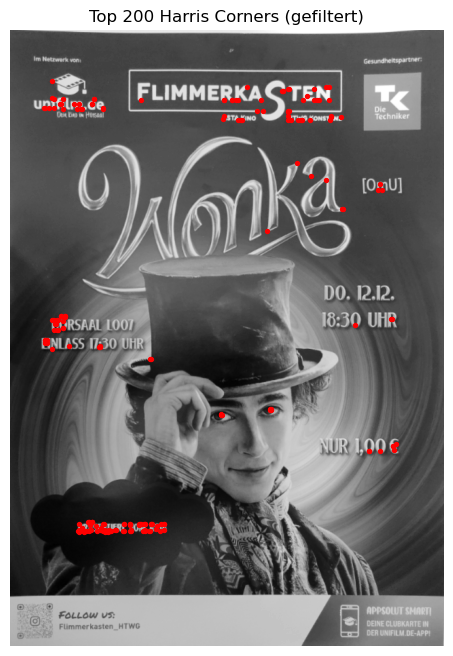

In [139]:
# ----------------------------------------
# Anwendungsteil Gesamtbild
# ----------------------------------------

# 1. Lade das Bild über relativen Pfad aus ../data/pzl_1/
image_full = load_grayscale_image(image_path_full)


# 2. Skalierung: halbiert das Bild, um Rechenlast zu reduzieren und glättet das Detailniveau
#image_full = image_full[::2, ::2]

# 3. Helligkeit normalisieren: bringt Werte in 0–255 Bereich → wichtig für stabilen Kontrast
image_full = (image_full - np.min(image_full)) / (np.max(image_full) - np.min(image_full)) * 255

# 4. Rauschen entfernen und Übergänge glätten, ohne Ecken zu zerstören
image_full = gaussian_filter(image_full, sigma=0.53)

# 5. Harris Corner Detection durchführen
corners_full, response_full = harris_corner_detection(
    image_full, 
    k=0.08,            # empfindlicher für Ecken mit kleinen Intensitätsänderungen
    window_size=3,     # kleines Fenster → präzise Lokalisierung
    threshold=0        # alle Punkte behalten, Filterung kommt danach
)

# 6. Ecken filtern: nur die stärksten 200 behalten
x_strong_full, y_strong_full = filter_strongest_corners(
    response_full, 
    threshold_ratio=0.025, 
    max_corners=200
)

# 7. Visualisierung
plt.figure(figsize=(8, 8))
plt.imshow(image_full, cmap='gray')
plt.scatter(x_strong_full, y_strong_full, c='red', s=8)
plt.title("Top 200 Harris Corners (gefiltert)")
plt.axis('off')
plt.show()

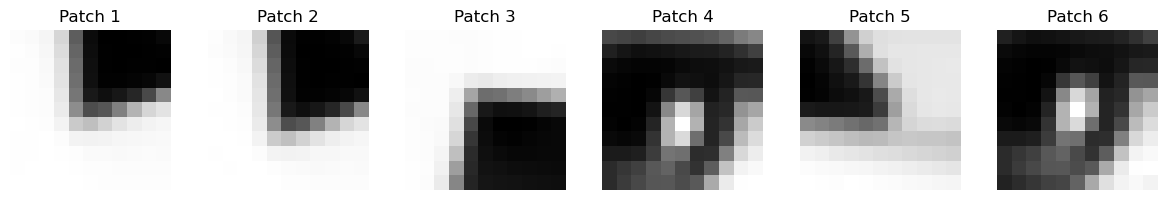

In [140]:
import numpy as np

def extract_normalized_patches(image, keypoints_x, keypoints_y, patch_size=11):
    """
    Extrahiert normalisierte quadratische Patches um jeden Keypoint aus einem Graustufenbild.

    Parameter:
    - image: 2D-Graustufenbild (z. B. vorverarbeitetes Puzzlebild)
    - keypoints_x: X-Koordinaten der Keypoints
    - keypoints_y: Y-Koordinaten der Keypoints
    - patch_size: Breite/Höhe des quadratischen Patches (ungerade Zahl, z. B. 11)

    Rückgabe:
    - descriptors: Liste von 1D-Vektoren mit normalisierten Pixelwerten
    - valid_x: X-Koordinaten der tatsächlich verwendeten Keypoints (nur die mit vollem Patch)
    - valid_y: Y-Koordinaten der tatsächlich verwendeten Keypoints
    """

    assert patch_size % 2 == 1, "patch_size muss ungerade sein (z. B. 11)."
    half = patch_size // 2

    descriptors = []
    valid_x = []
    valid_y = []

    for x, y in zip(keypoints_x, keypoints_y):
        # Stelle sicher, dass das Patch innerhalb des Bildes liegt
        if (x - half >= 0 and x + half < image.shape[1] and
            y - half >= 0 and y + half < image.shape[0]):

            patch = image[y - half:y + half + 1, x - half:x + half + 1].astype(np.float32)

            # Normalisiere Patch (zentrieren + skalieren)
            mean = np.mean(patch)
            std = np.std(patch)
            if std > 1e-5:
                patch = (patch - mean) / std  # Z-Score Normalisierung
            else:
                patch = patch - mean  # nur zentrieren, falls std ≈ 0

            descriptors.append(patch.flatten())  # als 1D-Vektor
            valid_x.append(x)
            valid_y.append(y)

    return np.array(descriptors), np.array(valid_x), np.array(valid_y)

def show_descriptor_patches(descriptors, patch_size=11, num_patches=6):
    """
    Zeigt die ersten `num_patches` Deskriptoren als Graubild-Patches an.

    Parameter:
    - descriptors: Liste oder Array von 1D-Deskriptor-Vektoren
    - patch_size: Seitenlänge des Patches (z. B. 11)
    - num_patches: Wie viele Patches angezeigt werden sollen
    """
    plt.figure(figsize=(2 * num_patches, 2))
    for i in range(min(num_patches, len(descriptors))):
        patch = descriptors[i].reshape((patch_size, patch_size))
        plt.subplot(1, num_patches, i + 1)
        plt.imshow(patch, cmap='gray')
        plt.axis('off')
        plt.title(f"Patch {i+1}")
    plt.tight_layout()
    plt.show()

# 1. Generate descriptors from image + keypoints
descriptors, x_valid, y_valid = extract_normalized_patches(
    image=image, 
    keypoints_x=x_strong, 
    keypoints_y=y_strong, 
    patch_size=11
)

# 2. Display the first few descriptor patches
show_descriptor_patches(descriptors, patch_size=11, num_patches=6)


# 1. Generate descriptors from image + keypoints 
descriptors_full, x_valid_full, y_valid_full = extract_normalized_patches(
    image=image_full, 
    keypoints_x=x_strong_full, 
    keypoints_y=y_strong_full, 
    patch_size=11
)




In [141]:
import numpy as np
import matplotlib.pyplot as plt

# ---------------------------
# Deskriptor-Matching (Brute Force + Ratio Test)
# ---------------------------
def match_descriptors(desc1, desc2, threshold=0.6):
    """
    Vergleicht zwei Mengen von Deskriptoren per L2-Distanz (Brute Force).
    Nimmt nur Matches auf, bei denen der beste Match deutlich besser ist als der zweitbeste (Ratio-Test).

    Args:
        desc1 (np.ndarray): Deskriptoren vom Puzzleteil, Form (N, D)
        desc2 (np.ndarray): Deskriptoren vom Gesamtbild, Form (M, D)
        threshold (float): Schwellenwert für den Ratio-Test

    Returns:
        matches (List[Tuple[int, int]]): Liste der Indizes (i, j) der gematchten Deskriptoren
    """
    matches = []
    for i, d1 in enumerate(desc1):
        dists = np.linalg.norm(desc2 - d1, axis=1)
        if len(dists) < 2:
            continue
        sorted_idx = np.argsort(dists)
        best, second_best = dists[sorted_idx[0]], dists[sorted_idx[1]]
        if best / second_best < threshold:
            matches.append((i, sorted_idx[0]))
    return matches

# ---------------------------
# Visualisierung
# ---------------------------
def plot_matches(img1, kp1, img2, kp2, matches, max_lines=50):
    """
    Zeigt gematchte Keypoints zwischen zwei Bildern mit Linien.

    Args:
        img1, img2: Bilder als Graustufen (2D np.ndarray)
        kp1, kp2: Keypoints als Listen von (x, y)-Tupeln
        matches: Liste von (i, j)-Tupeln (Indexpaare)
    """
    h1, w1 = img1.shape[:2]
    h2, w2 = img2.shape[:2]
    vis = np.zeros((max(h1, h2), w1 + w2), dtype=np.uint8)
    vis[:h1, :w1] = img1
    vis[:h2, w1:] = img2

    plt.figure(figsize=(12, 6))
    plt.imshow(vis, cmap='gray')
    for (i, j) in matches[:max_lines]:
        x1, y1 = kp1[i]
        x2, y2 = kp2[j]
        plt.plot([x1, x2 + w1], [y1, y2], 'cyan', linewidth=0.7)
        plt.plot(x1, y1, 'ro', markersize=3)
        plt.plot(x2 + w1, y2, 'go', markersize=3)
    plt.axis('off')
    plt.title(f"Top {len(matches[:max_lines])} Matches")
    plt.tight_layout()
    plt.show()






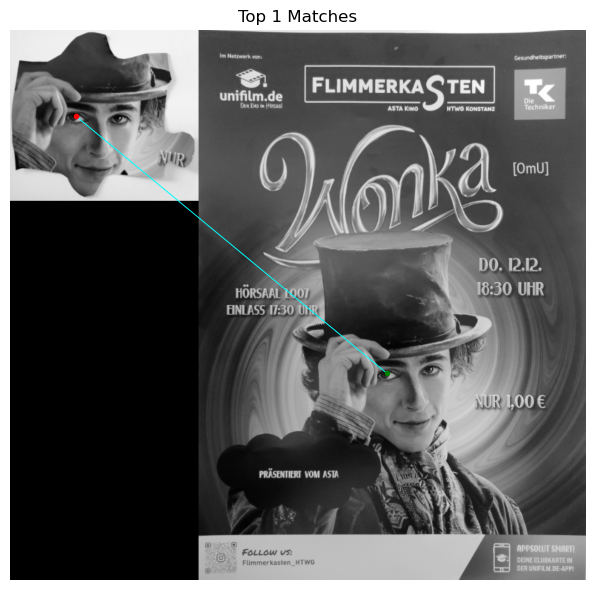

In [142]:

# Matches berechnen
matches = match_descriptors(descriptors, descriptors_full, threshold=0.6)

keypoints1= list(zip(x_strong, y_strong))
keypoints2 = list(zip(x_strong_full, y_strong_full))

# Matches visualisieren
plot_matches(img1=image, kp1=keypoints1, img2=image_full, kp2=keypoints2, matches=matches)


In [143]:
def sliding_window_matching_custom(
    image_full,
    image_patch,
    patch_kps,
    patch_desc,
    extract_patch_descriptors_fn,
    num_windows_x=2,
    num_windows_y=2,
    patch_size=11,
    match_threshold=0.6
):
    """
    Führt Sliding-Window-Matching durch, indem das große Bild in Fenster aufgeteilt wird.
    Jeder Bereich wird mit den Keypoints/Deskriptoren des Puzzleteils verglichen.

    Args:
        image_full: das große Bild (2D Graustufenbild)
        image_patch: das kleine Puzzleteilbild
        patch_kps: Keypoints im Puzzleteil [(x, y), ...]
        patch_desc: Deskriptoren im Puzzleteil, NxD
        extract_patch_descriptors_fn: Funktion zum Extrahieren der Deskriptoren
        num_windows_x: Anzahl Fenster horizontal
        num_windows_y: Anzahl Fenster vertikal
        patch_size: für Deskriptorenextraktion
        match_threshold: Ratio-Test Schwelle

    Returns:
        best_matches: Liste der besten Matches
        best_region: (x_start, y_start, x_end, y_end) im Gesamtbild
        matched_kp_full: Keypoints im Gesamtbild, passend zu best_matches
    """
    h_full, w_full = image_full.shape
    win_w = w_full // num_windows_x
    win_h = h_full // num_windows_y

    best_matches = []
    best_region = None
    matched_kp_full = []


    for i in range(num_windows_x):
        for j in range(num_windows_y):
            x_start = i * win_w
            y_start = j * win_h
            x_end = x_start + win_w
            y_end = y_start + win_h

            window = image_full[y_start:y_end, x_start:x_end]

            # Lokale Ecken berechnen
            corners_win, response_win = harris_corner_detection(window, k=0.08, window_size=3)
            x_win, y_win = filter_strongest_corners(response_win, threshold_ratio=0.03, max_corners=200)

            # Deskriptoren im Fenster extrahieren
            desc_win, x_valid, y_valid = extract_patch_descriptors_fn(window, x_win, y_win, patch_size=patch_size)

            if len(desc_win) == 0:
                continue

            # Deskriptoren matchen
            matches = match_descriptors(patch_desc, desc_win, threshold=match_threshold)

            # Prüfen, ob das beste Ergebnis ist
            if len(matches) > len(best_matches):
                best_matches = matches
                best_region = (x_start, y_start, x_end, y_end)
                #matched_kp_full = [(x_valid[j] + x_start, y_valid[j] + y_start) for (_, j) in matches]
                kp_full_all = list(zip(x_valid + x_start, y_valid + y_start))


    #return best_matches, best_region, matched_kp_full
    return best_matches, best_region, kp_full_all



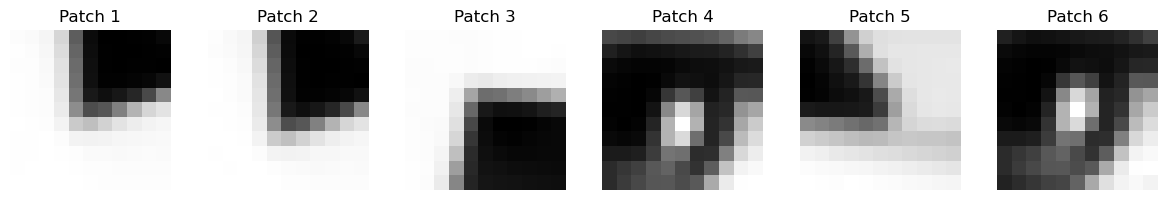

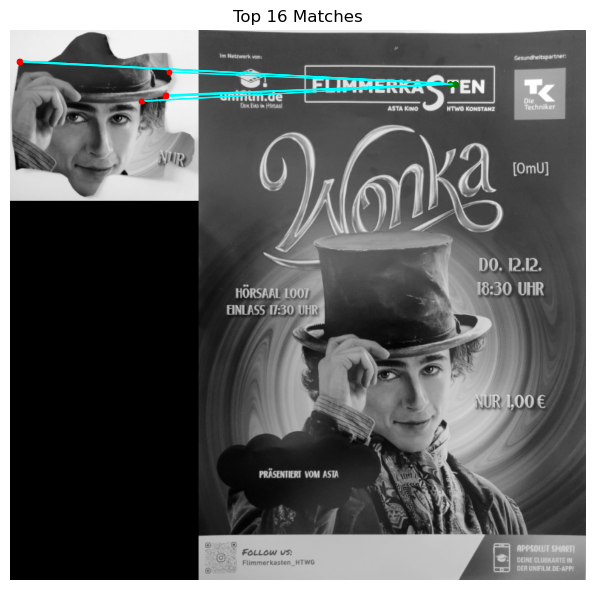

In [144]:
# Puzzleteil Deskriptoren erzeugen
descriptors, x_valid, y_valid = extract_normalized_patches(image, x_strong, y_strong)
patch_kps = list(zip(x_valid, y_valid))

# 2. Display the first few descriptor patches
show_descriptor_patches(descriptors, patch_size=11, num_patches=6)


# Sliding Window Matching
matches, region, kp_matched = sliding_window_matching_custom(
    image_full=image_full,
    image_patch=image,
    patch_kps=patch_kps,
    patch_desc=descriptors,
    extract_patch_descriptors_fn=extract_normalized_patches,
    num_windows_x=4,
    num_windows_y=4,
    patch_size=11,
    match_threshold=0.6
)

# Visualisierung
plot_matches(image, patch_kps, image_full, kp_matched, matches)
